<a href="https://colab.research.google.com/github/JanGorczynski/Sentiment_Analysis_project/blob/main/CudaProjekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
import gensim.downloader as api
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import LSTM,CuDNNLSTM, Dropout, Embedding, Conv1D, MultiHeadAttention, Input, Flatten, BatchNormalization, Dropout
from kerastuner import RandomSearch, HyperModel

<ipython-input-2-1c198f573c97>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch, HyperModel


# Data imports and preparation
In this section we loaded and prepared data for traning


In [ ]:

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab/IMDB Dataset.csv")

In [ ]:
df.columns = ["Review","Sentiment"]

In [ ]:
df.head()

,Review,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     50000 non-null  object
 1   Sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df["Sentiment"].value_counts()

positive    25000
negative    25000
Name: Sentiment, dtype: int64

In [ ]:
test = df["Review"][1]
print(test)

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.


Following fuction takes sentence and preparse it for traning by: <br>
1 Converting the word to lower case <br>
2 Removing html '< br />< br />' tag <br>
3 Removing non letter characters <br>
4 Removing stop words <br>
5 Lemmatizing words eg. gives -> give <br>

In [ ]:
def prep_sentence(sentence):
  lemmatizer = WordNetLemmatizer()
  sentence = sentence.lower()
  sentence = sentence.replace("<br /><br />"," ")
  sentence = re.sub("\'", "",sentence)
  sentence = re.sub(r'[^a-z]', ' ', sentence)

  sentence = sentence.split()
  stop_words = set(stopwords.words('english'))
  for word in sentence:
    if word in stop_words:
      sentence.remove(word)
  for i in range(len(sentence)):
    sentence[i] = lemmatizer.lemmatize(sentence[i])

  return " ".join(sentence)

In [ ]:
print(prep_sentence(test))

wonderful little production filming technique unassuming very old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen only got polari he all voice pat you truly see seamless editing guided reference williams diary entry only well worth watching it terrificly written performed piece a masterful production one the great master comedy his life the realism really come home the little thing the fantasy the guard rather use the traditional dream technique remains solid disappears it play our knowledge our sens particularly the scene concerning orton halliwell the set particularly their flat halliwells mural decorating every surface terribly well done


In [ ]:
print(df["Review"].isnull().sum())
print(df["Sentiment"].isnull().sum())

0
0


In [ ]:
df["Processed_review"] = df['Review'].apply(prep_sentence)

In [ ]:
df["Processed_review"]

0        one reviewer mentioned after watching oz episo...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically there family little boy jake think t...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    am catholic taught parochial elementary school...
49998    im going have disagree previous comment side m...
49999    one expects star trek movie be high art fan ex...
Name: Processed_review, Length: 50000, dtype: object

Since majority of reviews are between 0 and 250 words long, we decided to make word limit 250

<Axes: xlabel='Processed_review', ylabel='Count'>

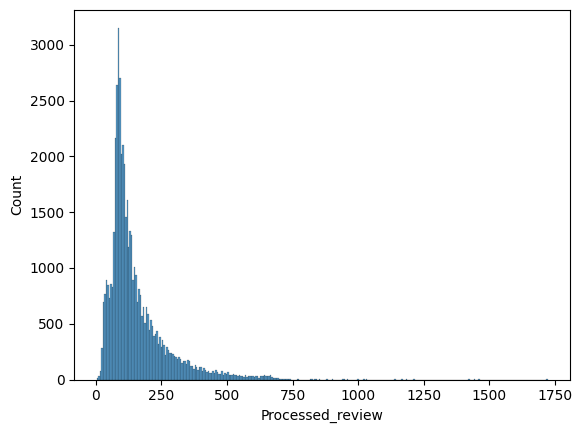

In [ ]:
sns.histplot(df["Processed_review"].apply(lambda x: len(x.split())))

In [ ]:
y_labels = []
for sentiment in df["Sentiment"]:
  if sentiment == "positive":
    y_labels.append(1)
  else:
    y_labels.append(0)

y_labels = np.array(y_labels)

for i in range(0,10):
  print(y_labels[i],df["Sentiment"][i])

1 positive
1 positive
1 positive
0 negative
1 positive
1 positive
1 positive
0 negative
0 negative
1 positive


In [ ]:
maxwords = 10000
max_len = 250
x_data = list(df["Processed_review"])

In [ ]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.2, random_state=101)

In [ ]:
tokenizer = Tokenizer(num_words=maxwords)
tokenizer.fit_on_texts(X_train_raw)
X_train = tokenizer.texts_to_sequences(X_train_raw)
X_test = tokenizer.texts_to_sequences(X_test_raw)
X_train = np.array(pad_sequences(X_train, maxlen=max_len))
X_test = np.array(pad_sequences(X_test, maxlen=max_len))

In [ ]:
print(X_train.shape)
print(X_test.shape)

(40000, 250)
(10000, 250)


This functions will be needed in predictions analysis

In [ ]:
def get_len(x):
  for i in range(len(x)):
    if(x[i]!=0):
      return len(x)-i
  return 0

In [ ]:
def to_cat(i):
  if(i<0.5):
    return 0
  else:
    return 1

# LSTM


## What is LSTM?
Lstm stands for Long Short-Term Memory. LSTM unit includes cell and gates - input, output and forget gate. Forget gate decides just simply which information is important and worth to remember and which should be rejected (0 or 1). Input gate places information in current state. Output gate decides which part of information is worth going to output.
Such solution is useful because the crucial information is in long term memory and have impact but less important infomation do not fill needlessly memory.

The reason why we mention LSTM here is the fact that LSTM which is reccurent neural networks, gives good results while working with sequences of words and here in reviews we have full sentences.

In [ ]:
def make_lstm_model():
  model = Sequential()
  model.add(Embedding(maxwords,25))
  model.add(CuDNNLSTM(48))
  model.add(Dense(1,activation = "sigmoid"))
  model.summary()
  model.compile(optimizer=Adam(learning_rate=0.01),loss="binary_crossentropy",metrics = "accuracy")
  return model

I started playing with models to make accuracy as high as I can, I assumed that accuracy about 0.9 will be my goal.

In [ ]:
model = make_lstm_model()
model.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_test,y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          250000    
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 48)                14400     
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 40s 205ms/step - loss: 0.4505 - accuracy: 0.7897 - val_loss: 0.3268 - val_accuracy: 0.8644
Epoch 2/10
157/157 [==============================] - 23s 146ms/step - loss: 0.2678 - accuracy: 0.8961 - val_loss: 0.2711 - val_accuracy: 0.8862
Epoch 3/10
157/157 [====

In [ ]:
def make_lstm_model():
  model2 = Sequential()
  model2.add(Embedding(maxwords,25))
  model2.add(CuDNNLSTM(48))
  model2.add(Dense(1,activation = "sigmoid"))
  model2.summary()
  model2.compile(optimizer=Adam(learning_rate=0.02),loss="binary_crossentropy",metrics = "accuracy")
  return model2

In [ ]:
model2 = make_lstm_model()
model2.fit(X_train,y_train,batch_size=256,epochs=15,validation_data=(X_test,y_test))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 25)          250000    
                                                                 
 cu_dnnlstm_14 (CuDNNLSTM)   (None, 48)                14400     
                                                                 
 dense_22 (Dense)            (None, 1)                 49        
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
157/157 [==============================] - 25s 142ms/step - loss: 0.4341 - accuracy: 0.7893 - val_loss: 0.2758 - val_accuracy: 0.8882
Epoch 2/15
157/157 [==============================] - 17s 108ms/step - loss: 0.2210 - accuracy: 0.9132 - val_loss: 0.2498 - val_accuracy: 0.9010
Epoch 3/15
157/157 [=

In [ ]:
def make_lstm_model():
  model3 = Sequential()
  model3.add(Embedding(maxwords,25))
  model3.add(CuDNNLSTM(32))
  model3.add(Dense(1,activation = "sigmoid"))
  model3.summary()
  model3.compile(optimizer=Adam(learning_rate=0.03),loss="binary_crossentropy",metrics = "accuracy")
  return model3

In [ ]:
model3 = make_lstm_model()
model3.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_test,y_test))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 25)          250000    
                                                                 
 cu_dnnlstm_6 (CuDNNLSTM)    (None, 32)                7552      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 257,585
Trainable params: 257,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 26s 151ms/step - loss: 0.5690 - accuracy: 0.7036 - val_loss: 0.6731 - val_accuracy: 0.6000
Epoch 2/10
157/157 [==============================] - 17s 107ms/step - loss: 0.4753 - accuracy: 0.7788 - val_loss: 0.3557 - val_accuracy: 0.8497
Epoch 3/10
157/157 [==

In [ ]:
def make_lstm_model():
  model4 = Sequential()
  model4.add(Embedding(maxwords,25))
  model4.add(CuDNNLSTM(32))
  model4.add(Dense(64,activation="relu"))
  model4.add(Dense(1,activation = "sigmoid"))
  model4.summary()
  model4.compile(optimizer=Adam(learning_rate=0.03),loss="binary_crossentropy",metrics = "accuracy")
  return model4

Here I decided to add some layer

In [ ]:
model4 = make_lstm_model()
model4.fit(X_train,y_train,batch_size=150,epochs=15,validation_data=(X_test,y_test))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 25)          250000    
                                                                 
 cu_dnnlstm_8 (CuDNNLSTM)    (None, 32)                7552      
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 259,729
Trainable params: 259,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
267/267 [==============================] - 50s 177ms/step - loss: 0.4881 - accuracy: 0.7742 - val_loss: 0.3670 - val_accuracy: 0.8427
Epoch 2/15
267/267 [===============

In [ ]:
def make_lstm_model():
  model5 = Sequential()
  model5.add(Embedding(maxwords,25))
  model5.add(CuDNNLSTM(32))
  model5.add(Dense(32,activation="relu"))
  model5.add(Dense(1,activation = "sigmoid"))
  model5.summary()
  model5.compile(optimizer=Adam(learning_rate=0.02),loss="binary_crossentropy",metrics = "accuracy")
  return model5

Played with batch size, number of epochs and learning rate

In [ ]:
model5 = make_lstm_model()
model5.fit(X_train,y_train,batch_size=256,epochs=10,validation_data=(X_test,y_test))

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, None, 25)          250000    
                                                                 
 cu_dnnlstm_27 (CuDNNLSTM)   (None, 32)                7552      
                                                                 
 dense_28 (Dense)            (None, 32)                1056      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 258,641
Trainable params: 258,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 26s 154ms/step - loss: 0.4568 - accuracy: 0.7884 - val_loss: 0.4179 - val_accuracy: 0.8277
Epoch 2/10
157/157 [==============

In [ ]:
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization


In [ ]:
def make_lstm_model():
  model6 = Sequential()
  model6.add(Embedding(maxwords,25))
  model6.add(CuDNNLSTM(64))
  model6.add(Dense(64,activation="relu"))
  model6.add(Dense(1,activation="sigmoid"))
  model6.summary()
  model6.compile(optimizer=Adam(learning_rate=0.03),loss="binary_crossentropy",metrics = "accuracy")
  return model6

In [ ]:
model6 = make_lstm_model()
model6.fit(X_train,y_train,batch_size=300,epochs=15,validation_data=(X_test,y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          250000    
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 64)                23296     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 277,521
Trainable params: 277,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
134/134 [==============================] - 38s 210ms/step - loss: 0.4762 - accuracy: 0.7766 - val_loss: 0.3198 - val_accuracy: 0.8674
Epoch 2/15
134/134 [=================

In [ ]:
def make_lstm_model():
  model7 = Sequential()
  model7.add(Embedding(maxwords,25))
  model7.add(CuDNNLSTM(32))
  model7.add(Dense(32,activation="relu"))
  model7.add(Dense(64,activation="relu"))
  model7.add(Dropout(0.2))
  model7.add(Dense(1,activation="sigmoid"))
  model7.summary()
  model7.compile(optimizer=Adam(learning_rate=0.02),loss="binary_crossentropy",metrics = "accuracy")
  return model7

Decided to use dropout to make better results

In [ ]:
model7 = make_lstm_model()
model7.fit(X_train,y_train,batch_size=300,epochs=15,validation_data=(X_test,y_test))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 25)          250000    
                                                                 
 cu_dnnlstm_4 (CuDNNLSTM)    (None, 32)                7552      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 260,785
Trainable params: 260,785
Non-tr

First model where I succeeded in crossing 0.88 accuracy

In [ ]:
def make_lstm_model():
  model8 = Sequential()
  model8.add(Embedding(maxwords,25))
  model8.add(CuDNNLSTM(64))
  model8.add(Dense(64,activation="relu"))
  model8.add(Dropout(0.1))
  model8.add(Dense(64,activation="relu"))
  model8.add(Dropout(0.2))
  model8.add(Dense(1,activation="sigmoid"))
  model8.summary()
  model8.compile(optimizer=Adam(learning_rate=0.02),loss="binary_crossentropy",metrics = "accuracy")
  return model8

In [ ]:
model8 = make_lstm_model()
model8.fit(X_train,y_train,batch_size=500,epochs=10,validation_data=(X_test,y_test))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 25)          250000    
                                                                 
 cu_dnnlstm_17 (CuDNNLSTM)   (None, 64)                23296     
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 1)               

I had a problem with overtraining my dataset so I tried to make learning rate lower etc


In [ ]:
def make_lstm_model():
  model = Sequential()
  model.add(Embedding(maxwords,25))
  model.add(CuDNNLSTM(64))
  model.add(Dropout(0.5))
  model.add(Dense(64,activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(1,activation="sigmoid"))
  model.summary()
  model.compile(optimizer=Adam(learning_rate=0.01),loss="binary_crossentropy",metrics = "accuracy")
  return model

In [ ]:
model9 = make_lstm_model()
model9.fit(X_train,y_train,batch_size=500,epochs=5,validation_data=(X_test,y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 25)          250000    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 64)                23296     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 277,521
Trainable params: 277,521
Non-tr

In [ ]:
predictions = model9.predict(X_test)

313/313 [==============================] - 1s 5ms/step


I did not achieve the 0.9 goal despite the fact that I tried and created much more models than here is presented. But for now the result about 0.882 is satisfying.

In [ ]:
predictions = [ to_cat(i) for i in predictions]

In [ ]:
df = pd.DataFrame(predictions, columns = ["pred"])
df["true_val"] = y_test
df["is_true"] = (df["true_val"] == df["pred"])
df["len"] = pd.Series([get_len(i) for i in X_test])

<Axes: xlabel='len', ylabel='Count'>

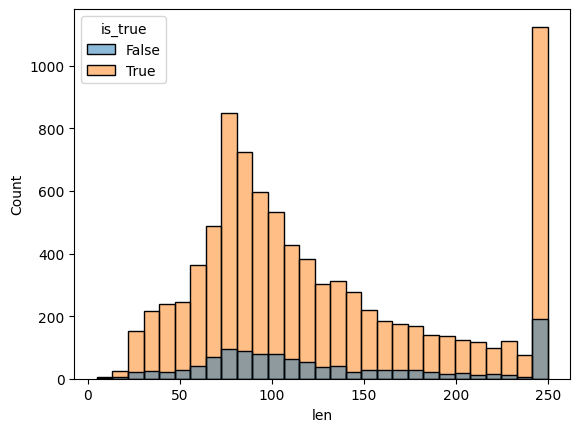

In [ ]:
sns.histplot(data = df, x = "len",hue = "is_true")

# CNN

A Convolutional Neural Network (CNN) is a type of artificial neural network designed specifically for processing and analyzing visual data, such as images and videos. CNNs are widely used in computer vision tasks like image classification, object detection, facial recognition, and more. They are inspired by the human visual system's ability to identify patterns and features in visual information.

In [ ]:
def make_CNN_model():
  model = Sequential()
  model.add(Input(shape=(250,)))
  model.add(Embedding(maxwords,25))
  model.add(Conv1D(64,5,padding = "same",activation = "relu"))

  model.add(Flatten())
  model.add(Dense(64,activation="relu"))
  model.add(Dense(32,activation="relu"))
  model.add(Dense(16,activation = "relu"))
  model.add(Dense(1,activation = "sigmoid"))
  model.compile(optimizer=Adam(learning_rate=0.0001),loss="binary_crossentropy",metrics = "accuracy")
  return model

In [ ]:
y_train.shape

(40000,)

In [ ]:
X_train_conv = X_train.reshape(X_train.shape[0],X_train.shape[1],1).astype(float)
X_test_conv = X_test.reshape(X_test.shape[0],X_test.shape[1],1).astype(float)
y_train_conv = y_train.reshape(y_train.shape[0],1).astype(float)
y_test_conv = y_test.reshape(y_test.shape[0],1).astype(float)

In [ ]:
model = make_CNN_model()
model.fit(X_train_conv,y_train_conv,batch_size=256,epochs=10,validation_data=(X_test_conv,y_test_conv))

Epoch 1/10
157/157 [==============================] - 46s 210ms/step - loss: 0.6928 - accuracy: 0.5109 - val_loss: 0.6923 - val_accuracy: 0.5207
Epoch 2/10
157/157 [==============================] - 20s 130ms/step - loss: 0.5972 - accuracy: 0.6933 - val_loss: 0.3554 - val_accuracy: 0.8513
Epoch 3/10
157/157 [==============================] - 14s 87ms/step - loss: 0.2880 - accuracy: 0.8824 - val_loss: 0.2791 - val_accuracy: 0.8861
Epoch 4/10
157/157 [==============================] - 13s 83ms/step - loss: 0.2272 - accuracy: 0.9115 - val_loss: 0.2646 - val_accuracy: 0.8926
Epoch 5/10
157/157 [==============================] - 8s 52ms/step - loss: 0.1973 - accuracy: 0.9252 - val_loss: 0.2732 - val_accuracy: 0.8876
Epoch 6/10
157/157 [==============================] - 8s 52ms/step - loss: 0.1778 - accuracy: 0.9333 - val_loss: 0.2663 - val_accuracy: 0.8931
Epoch 7/10
157/157 [==============================] - 5s 33ms/step - loss: 0.1602 - accuracy: 0.9419 - val_loss: 0.2716 - val_accuracy: 

In [ ]:
X_train.shape

(40000, 250)

In [ ]:
pred_test = model.predict(X_test_conv)
pred_test = [ to_cat(i) for i in pred_test]
df = pd.DataFrame(pred_test, columns = ["pred"])
df["true_val"] = y_test
df["is_true"] = (df["true_val"] == df["pred"])
df["len"] = pd.Series([get_len(i) for i in X_test])

313/313 [==============================] - 1s 2ms/step


<Axes: xlabel='len', ylabel='Count'>

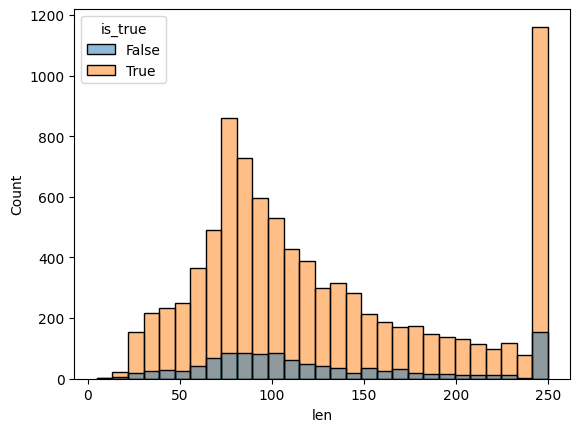

In [ ]:
sns.histplot(data = df, x = "len",hue = "is_true")

# ATTENTION

Our third model is an attention based network. It uses embeding to convert words into numerical vectors for our networks input, embeding layers are also trained, after some epochs they place the words in vector space where distance between them is correlated to their meaning, the closer the words the closer the meaning. Next layers are multihead attention layers. Single attention layer finds relevant information in the data by multiplying queries and keys which essentially is like looking for correlation between words in text. Multihead attention is many attention layers connected parallel to each other. This mechanism has certain advantages over LSTM and CNN models, mainly its not affected by exploding gradients problem, this means that no matter how far 2 words are in the text, network wont have a problem with corelating their meaning. This type of layer is backbone of the Transformer architecture which is used in many NLP aplications like LLM's for example ChatGPT or LLaMA. After multihead attention are fully concted layers and an output layer for making prediction. I used keras tuner to find good set of hyperparameters.

In [ ]:
class AttentionHP(HyperModel):


  def build(self, hp):

    inputs = Input(shape=(250,1))

    embeding = Embedding(10000,25)(inputs)

    attention = MultiHeadAttention(num_heads=hp.Int('Number_of_heads', min_value=4, max_value=12, step=2), ekey_dim=64)(embeding, embeding)



    flatten = Flatten()(attention)


    dense = Dense(units=64, activation='relu')(flatten)

    for i in range(hp.Int("nubmer Of extra deep layers",min_value=1, max_value=2)):
      dense = Dense(units= hp.Int(f"units_{i+1}_layer", min_value=32, max_value=64, step=16), activation='relu')(dense)

    drop = Dropout(0.4)(dense)


    outputs = Dense(units=1, activation='sigmoid')(dense)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.01),loss="binary_crossentropy",metrics = "accuracy")
    return model

In [ ]:
tuner = RandomSearch(
    AttentionHP(),
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    directory='Atention_logs'
)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=10,batch_size = 256, validation_data=(X_test,y_test), callbacks = [stop_early])

Trial 8 Complete [00h 04m 06s]
val_accuracy: 0.8953999876976013

Best val_accuracy So Far: 0.8953999876976013
Total elapsed time: 00h 28m 56s


In [ ]:
attention_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
predictions =  attention_model.predict(X_test)

313/313 [==============================] - 3s 10ms/step


In [ ]:
predictions = [ to_cat(i) for i in predictions]

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4959
           1       0.89      0.91      0.90      5041

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
print(pd.DataFrame(confusion_matrix(y_test,predictions),columns = ["Positive values", "Negative values"],
                   index = ["Positive guesses", "Negative guesses"]))

                  Positive values  Negative values
Positive guesses             4365              594
Negative guesses              452             4589


In [ ]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
df = pd.DataFrame(predictions, columns = ["pred"])
df["true_val"] = y_test
df["is_true"] = (df["true_val"] == df["pred"])
df["len"] = pd.Series([get_len(i) for i in X_test])

<Axes: xlabel='len', ylabel='Count'>

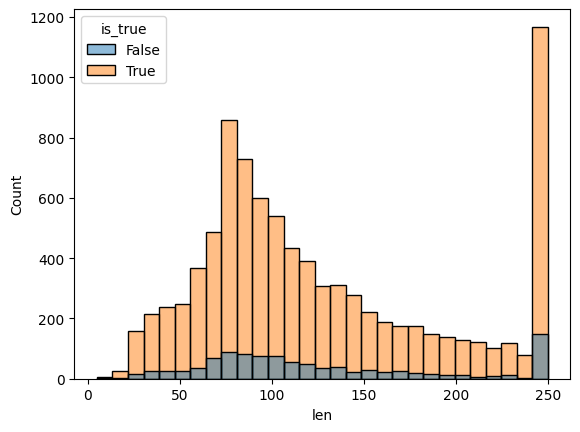

In [ ]:
sns.histplot(data = df, x = "len",hue = "is_true")

# Summary
All of our aproches produced models that achived around 90% accuracy. Because our reviews weren't very long we didn't have problems with exploding gradients thus LSTM's and CNN's got good results. This type of sentiment analysis is very common task for data enginers and there are many more aproches than we showed like bidirectional LSTM's or unsupervised aproches like K means clustering. <br><br>

This project was created by: <br>
Marta Figurska <br>
Marcel Raczek <br>
Jan Gorczyński <br>

# Bonus section
Recently there was a paper describing new method of sentiment analysis using KNN algorithm with zip compression based distance metric. We decided to test this aproach on our data and were shocked when it achived 90% accuracy. Since this aproach is very computationally expensive in python we only tested on sample with 100 examples.

In [ ]:
df

,Review,Sentiment,Processed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned after watching oz episo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job wasnt creative or...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,am catholic taught parochial elementary school...
49998,I'm going to have to disagree with the previou...,negative,im going have disagree previous comment side m...


In [ ]:
df["Review"] = df["Review"].apply(lambda x : x.replace("<br /><br />"," "))

In [ ]:
X = df["Review"]
y = df["Sentiment"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
test_set = np.array(pd.concat([X_train,y_train ], axis=1))
training_set = np.array(pd.concat([X_test,y_test], axis=1))

In [ ]:
test_set[0].shape

(2,)

In [ ]:
def countSentiment(top_k_class):
  postive = 0
  negative = 0
  for i in top_k_class:
    if i== 'negative':
      negative +=1
    else:
      postive +=1
  if negative>postive:
    return 'negative'
  else:
    return 'positive'

In [ ]:
predictions_table = pd.DataFrame(columns = ["k", "accuracy"])

In [ ]:
number_of_guesses = 100

In [ ]:
import gzip
i = 0
for k in [80,100,120]:
  predictions = []
  for ( x1 , _ ) in test_set[:number_of_guesses]:
    i += 1
    Cx1 = len( gzip.compress ( x1.encode() ) )
    distance_from_x1 = []
    for ( x2 , _ ) in training_set :
      Cx2 = len( gzip.compress( x2.encode()) )
      x1x2 = " ".join([ x1 , x2 ])
      Cx1x2 = len( gzip.compress( x1x2.encode() ))
      ncd = ( Cx1x2 - min( Cx1 , Cx2 ) ) / max(Cx1 , Cx2 )
      distance_from_x1.append ( ncd )
      sorted_idx = np.argsort ( np.array(distance_from_x1 ) )
    top_k_class = training_set[ sorted_idx[:k ] , 1]
    predict_class = countSentiment(top_k_class)
    predictions.append(predict_class)
    print(k,i)

  correct = 0
  for i in range(number_of_guesses):
    if(test_set[i,1] == predictions[i]):
      correct += 1
  new_pred = {
      "k":k,
      "accuracy": (correct/number_of_guesses)
  }
  predictions_table = pd.concat([predictions_table,pd.DataFrame([new_pred])],ignore_index= True)


80 1
80 2
80 3
80 4
80 5
80 6
80 7
80 8
80 9
80 10
80 11
80 12
80 13
80 14
80 15
80 16
80 17
80 18
80 19
80 20
80 21
80 22
80 23
80 24
80 25
80 26
80 27
80 28
80 29
80 30
80 31
80 32
80 33
80 34
80 35
80 36
80 37
80 38
80 39
80 40
80 41
80 42
80 43
80 44
80 45
80 46
80 47
80 48
80 49
80 50
80 51
80 52
80 53
80 54
80 55
80 56
80 57
80 58
80 59
80 60
80 61
80 62
80 63
80 64
80 65
80 66
80 67
80 68
80 69
80 70
80 71
80 72
80 73
80 74
80 75
80 76
80 77
80 78
80 79
80 80
80 81
80 82
80 83
80 84
80 85
80 86
80 87
80 88
80 89
80 90
80 91
80 92
80 93
80 94
80 95
80 96
80 97
80 98
80 99
80 100
100 100
100 101
100 102
100 103
100 104
100 105
100 106
100 107
100 108
100 109
100 110
100 111
100 112
100 113
100 114
100 115
100 116
100 117
100 118
100 119
100 120
100 121
100 122
100 123
100 124
100 125
100 126
100 127
100 128
100 129
100 130
100 131
100 132
100 133
100 134
100 135
100 136
100 137
100 138
100 139
100 140
100 141
100 142
100 143
100 144
100 145
100 146
100 147
100 148
100 149
100 150


In [ ]:
predictions_table

,k,accuracy
0,80,0.85
1,100,0.90
2,120,0.87
